<a href="https://colab.research.google.com/github/AlessandroMessori/ANN_Challenge_1/blob/main/Transfer_Learning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [3]:
%cd /gdrive/MyDrive/ANN&DL/Challenge

/gdrive/MyDrive/ANN&DL/Challenge


In [4]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix
from PIL import Image
from tensorflow.keras.applications.vgg16 import preprocess_input

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


In [5]:
# Random seed for reproducibility
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

In [6]:
dataset_dir = 'training'
labels = ['Apple','Blueberry','Cherry','Corn','Grape','Orange','Peach','Pepper','Potato','Raspberry','Soybean','Squash','Strawberry','Tomato']

In [7]:
batch_size = 32
img_height = 256
img_width = 256
input_shape = (256,256,3)
epochs = 200

In [8]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode= 'categorical')

Found 17728 files belonging to 14 classes.
Using 14183 files for training.


In [9]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  dataset_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size,
  label_mode = 'categorical')

Found 17728 files belonging to 14 classes.
Using 3545 files for validation.


58900480/58889256 [==============================] - 1s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

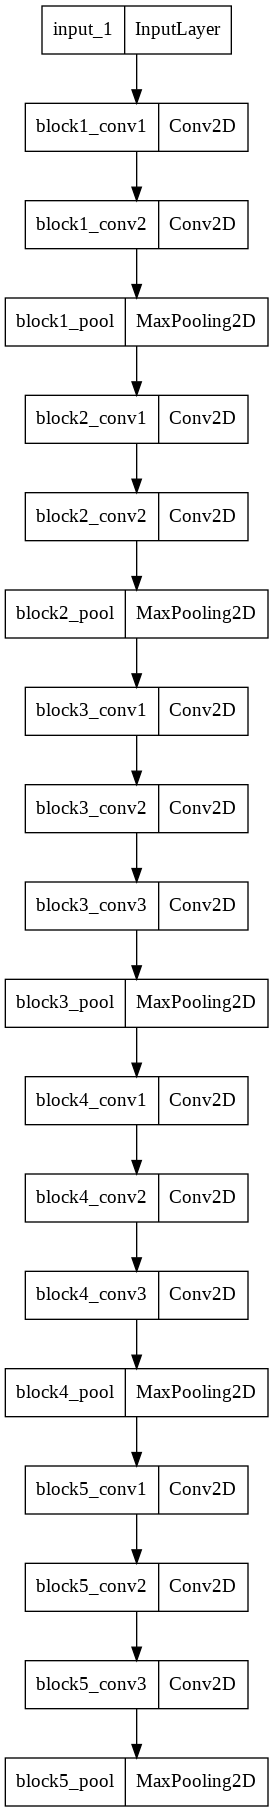

In [11]:
# Download and plot the VGG16 model
supernet = tfk.applications.VGG16(
    include_top=False,
    weights="imagenet",
    input_shape=(256,256,3)
)
supernet.summary()
tfk.utils.plot_model(supernet)

In [12]:
# Use the supernet as feature extractor
supernet.trainable = False

inputs = tfk.Input(shape=(img_height,img_width,3))
x = preprocess_input(inputs)
x = tfkl.Resizing(256,256, interpolation='bicubic')(x)
x = supernet(x)
x = tfkl.Flatten(name='Flattening')(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
x = tfkl.Dense(
    256, 
    activation='relu',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)
x = tfkl.Dropout(0.3, seed=seed)(x)
outputs = tfkl.Dense(
    14, 
    activation='softmax',
    kernel_initializer = tfk.initializers.GlorotUniform(seed))(x)


# Connect input and output through the Model class
tl_model = tfk.Model(inputs=inputs, outputs=outputs, name='model')

# Compile the model
tl_model.compile(loss=tfk.losses.CategoricalCrossentropy(), optimizer=tfk.optimizers.Adam(), metrics='accuracy')
tl_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resizing (Resizing)         (None, 256, 256, 3)       0         
                                                                 
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 Flattening (Flatten)        (None, 32768)             0         
                                                             

In [13]:
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [14]:
# Train the model
history = tl_model.fit(
    train_ds,
    batch_size = batch_size,
    epochs = epochs,
    validation_data = val_ds,
    callbacks = [tfk.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10, restore_best_weights=True)]
).history

Epoch 1/200
444/444 [==============================] - 1262s 3s/step - loss: 1.0166 - accuracy: 0.8360 - val_loss: 0.2284 - val_accuracy: 0.9419
Epoch 2/200
444/444 [==============================] - 201s 453ms/step - loss: 0.3874 - accuracy: 0.9109 - val_loss: 0.2192 - val_accuracy: 0.9498
Epoch 3/200
444/444 [==============================] - 200s 450ms/step - loss: 0.2772 - accuracy: 0.9329 - val_loss: 0.2087 - val_accuracy: 0.9673
Epoch 4/200
444/444 [==============================] - 199s 448ms/step - loss: 0.2285 - accuracy: 0.9453 - val_loss: 0.2164 - val_accuracy: 0.9597
Epoch 5/200
444/444 [==============================] - 199s 446ms/step - loss: 0.2036 - accuracy: 0.9531 - val_loss: 0.1787 - val_accuracy: 0.9642
Epoch 6/200
444/444 [==============================] - 199s 446ms/step - loss: 0.1685 - accuracy: 0.9621 - val_loss: 0.1795 - val_accuracy: 0.9757
Epoch 7/200
444/444 [==============================] - 198s 446ms/step - loss: 0.1746 - accuracy: 0.9640 - val_loss: 0.1

In [15]:
tl_model.save('Transfer_Learning_Model')

INFO:tensorflow:Assets written to: Transfer_Learning_Model/assets


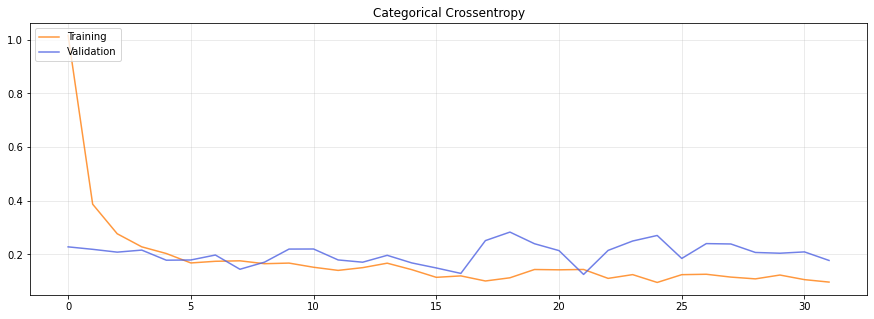

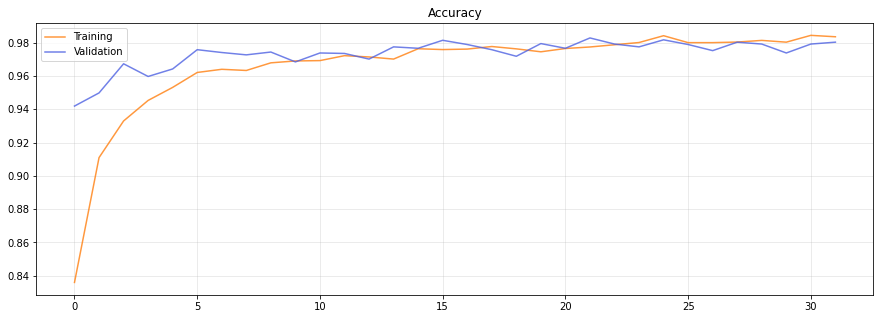

In [16]:
# Plot the training
plt.figure(figsize=(15,5))
plt.plot(history['loss'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Categorical Crossentropy')
plt.grid(alpha=.3)

plt.figure(figsize=(15,5))
plt.plot(history['accuracy'], label='Training', alpha=.8, color='#ff7f0e')
plt.plot(history['val_accuracy'], label='Validation', alpha=.8, color='#4D61E2')
plt.legend(loc='upper left')
plt.title('Accuracy')
plt.grid(alpha=.3)

plt.show()

In [17]:
max(history['val_accuracy'])

0.9827926754951477